## Ejemplo: Identificación de spam

El ejemplo proviene de Hastie, T; Tibshirani, R; Friedman, J. 2009. The Elements of Statistical Learning: Data Mining, Inference
and Prediction. Los datos fueron donados por George Forman (gforman at nospam hpl.hp.com)

### Librerías necesarias

In [40]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import  accuracy_score, mean_squared_error, roc_curve, auc, classification_report

#Estilo de gráfico
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10 ,6)

El modelo a implementar busca predecir si un mail específico corresponde o no a spam dadas ciertas características del texto. Dentro de ellas se encuentran 48 campos que cuentan la frecuencia de ciertas palabras, siguiendo la nomenclatura word_freq_< nombrepalabra>.


También se incluye la extensión del mail, la cantidad de símbolos y si menciona el nombre de George (el dueño de los mails).


In [3]:
#Carga de csv
df = pd.read_csv('spamdata_esl_colnames.csv').drop(columns= 'Unnamed: 0' )

In [4]:
# Información de columnas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4601 entries, 0 to 4600
Data columns (total 58 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   word_freq_make              4601 non-null   float64
 1   word_freq_address           4601 non-null   float64
 2   word_freq_all               4601 non-null   float64
 3   word_freq_3d                4601 non-null   float64
 4   word_freq_our               4601 non-null   float64
 5   word_freq_over              4601 non-null   float64
 6   word_freq_remove            4601 non-null   float64
 7   word_freq_internet          4601 non-null   float64
 8   word_freq_order             4601 non-null   float64
 9   word_freq_mail              4601 non-null   float64
 10  word_freq_receive           4601 non-null   float64
 11  word_freq_will              4601 non-null   float64
 12  word_freq_people            4601 non-null   float64
 13  word_freq_report            4601 

Al inspeccionar los datos y extraer las principales características observamos que aproximadamente el 40% de los mails contenidos se identificaron como correo no deseado.

0    0.605955
1    0.394045
Name: spam, dtype: float64


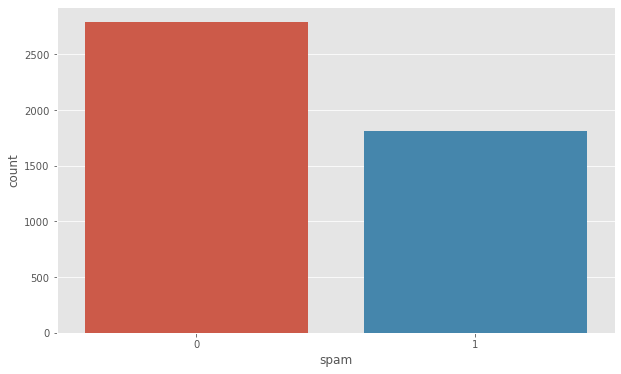

In [5]:
sns.countplot(df['spam'])
print(df['spam'].value_counts('%'))

Podemos observar la ocurrencia de algunos atributos entre mails clasificados como spam o no.


En la figura de la izquierda comparamos la frecuencia entre ciertas palabras para ambos grupos.


En la figura derecha calculamos el diferencial entre ambos grupos. 


Se observa que palabras como "you", "your", "free", y "our" presentan una prevalencia en los mails clasificados como spam. En contraparte, las palabras más comunes entre los mails clasificados como no Spam son aquellos que hacen referencia a información específica del usuario, como su nombre (George) y dónde trabaja (HP).

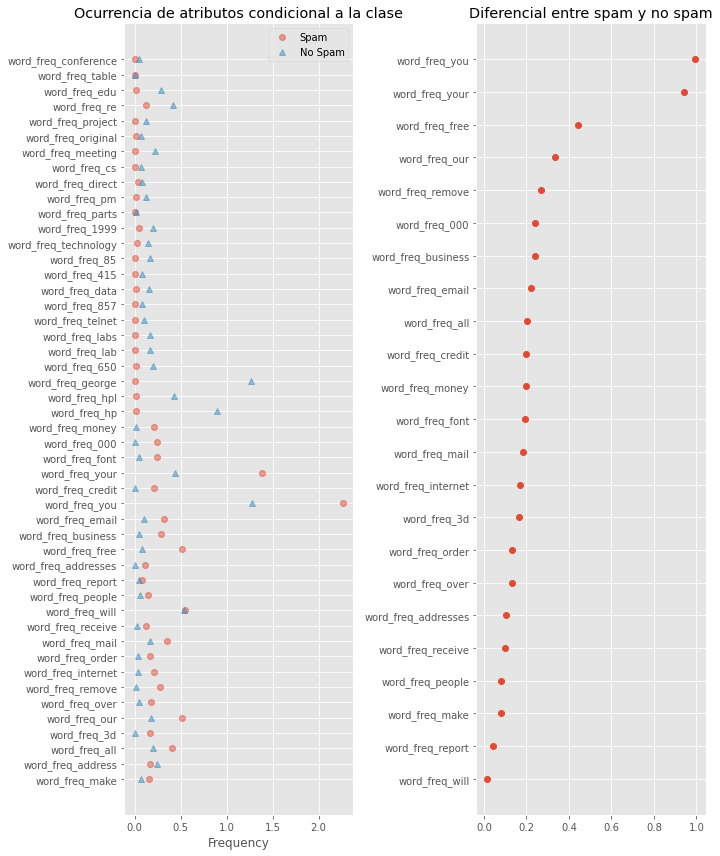

In [8]:
plt.figure(figsize=(10, 12))
plt.subplot(1, 2, 1)

# separamos las columnas que comiencen con word_freq

exclude_df = df.filter(regex='word_freq_*')
exclude_df['spam'] = df['spam']

# calculamos la media por grupo de cada columna

store_means_no_spam = exclude_df.query('spam == 0').drop(columns= 'spam').apply( lambda x: np.mean(x), axis= 0)
store_means_spam = exclude_df.query('spam ==1').drop(columns= 'spam').apply( lambda x: np.mean(x), axis= 0)

# Graficamos

plt.plot(store_means_spam, store_means_spam.index, 'o' , alpha= .5 , label= "Spam" )
plt.plot(store_means_no_spam, store_means_no_spam.index, '^' , alpha= .5 , label= "No Spam" )

plt.xlabel( 'Frequency' )
plt.title( 'Ocurrencia de atributos condicional a la clase' )

plt.legend();

plt.subplot( 1 , 2 , 2 )

# calculamos diferencial
store_diff = store_means_spam - store_means_no_spam

# ordenamos y mantenemos sólo los positivos
store_diff = store_diff[store_diff > 0 ].sort_values()

#Graficamos

plt.plot(store_diff, store_diff.index, 'o')
plt.title('Diferencial entre spam y no spam')
plt.tight_layout()

Ahora vamos a entrenar un clasificador adaptativo con sklearn.ensemble.AdaBoostClassifier.

La implementación del algoritmo se encuentra en sklearn.ensemble.AdaBoostClassifier. 

Los pasos para implementarlo son los mismos pasos de cualquier algoritmo sklearn.

In [10]:
#Separamos conjunto de entrenamiento y test

X_train, X_test, y_train, y_test = train_test_split(df.loc[:,'word_freq_make' : 'capital_run_length_total'],
                                                    df['spam'],test_size= .33 , random_state= 11238)

Adaptative Boosting aprovecha múltiples clasificadores débiles, donde su variante más común es un árbol de decisión con una profundidad mínima. En la literatura se conoce como una "decision stump". Este es el modelo que se implementa por defecto en la clase AdaBoostClassifier.

En una primera iteración, mantendremos la cantidad de hiper parámetros de AdaBoostClassifier al mínimo. Esto implica definir una semilla pseudoaleatoria para facilitar la replicación de resultados, así como un entrenamiento con decision stump con
fines comparativos.

In [12]:
# Entrenamos el decision stump

decision_stump = DecisionTreeClassifier(max_depth= 1, random_state= 11238).fit(X_train, y_train)

# Entrenamos el clasificador con adaptive boosting

adaboost_classifier = AdaBoostClassifier(base_estimator=decision_stump, random_state= 11238).fit(X_train, y_train)

In [13]:
# guardamos las predicciones de ambos modelos

tree_y_hat = decision_stump.fit(X_train, y_train).predict(X_test)

adaboost_y_hat = adaboost_classifier.fit(X_train, y_train).predict(X_test)

adaboost_pr = adaboost_classifier.fit(X_train, y_train).predict_proba(X_test)

# generamos el reporte

print( "Decision Stump:" )
print(classification_report(y_test, tree_y_hat, digits= 3))
print( "\n\nAdaptative Boosting Classifier:" )
print( "Cantidad de Estimadores:" , adaboost_classifier.n_estimators, "\n" )
print(classification_report(y_test, adaboost_y_hat, digits= 3 ))

Decision Stump:
              precision    recall  f1-score   support

           0      0.844     0.793     0.817       912
           1      0.715     0.779     0.745       607

    accuracy                          0.787      1519
   macro avg      0.779     0.786     0.781      1519
weighted avg      0.792     0.787     0.789      1519



Adaptative Boosting Classifier:
Cantidad de Estimadores: 50 

              precision    recall  f1-score   support

           0      0.939     0.950     0.944       912
           1      0.923     0.908     0.915       607

    accuracy                          0.933      1519
   macro avg      0.931     0.929     0.930      1519
weighted avg      0.933     0.933     0.933      1519



Analizando los resultados del decision stump, cabe destacar que el desempeño del modelo medido con f1-score, es mejor en la predicción de aquellos mails que no son spam (Clase 0).


Por defecto, al entrenar un modelo con AdaBoost y un total de 50 árboles con un mínimo de profundidad, el desempeño es un 15% superior que un decision stump (medido con f1-score). Otro aspecto a considerar es que el desempeño condicional a cada clase predicha disminuyó sus brecha, teniendo un desempeño mucho más homogéneo a lo largo de todas las clases.

Ahora compararemos el desempeño de AdaBoostClassifier contra otros clasificadores como RandomForest y DecisionTree

In [60]:
#Entrenamos los modelos

tree_decision_stump = DecisionTreeClassifier(max_depth= 1).fit(X_train, y_train)

tree_model = DecisionTreeClassifier().fit(X_train, y_train)

rf_model = RandomForestClassifier(max_depth= 1).fit(X_train, y_train)

adaboost_model = AdaBoostClassifier(base_estimator = tree_decision_stump, random_state= 11238).fit(X_train, y_train)

 Score DecisionTree:  0.907 
 Score RandomForest:  0.955 
 Score AdaBoost:  0.974


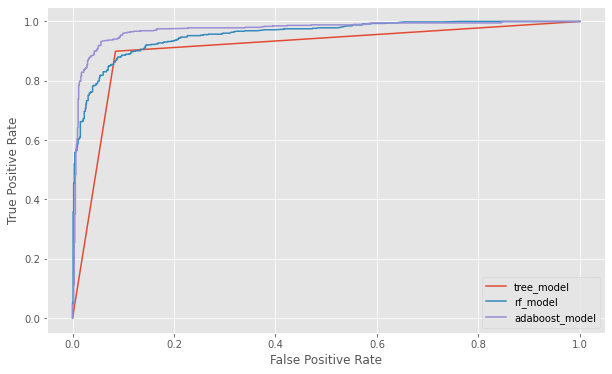

In [61]:
#Generamos la predicción

tmp_y_pred_tree = tree_model.predict_proba(X_test)[:, 1]
tmp_y_pred_rf = rf_model.predict_proba(X_test)[:, 1]
tmp_y_pred_ab = adaboost_model.predict_proba(X_test)[:, 1]

#Tasa de falsos positivos

false_positive_rates_tree, true_positive_rates_tree, _ = roc_curve(y_test, tmp_y_pred_tree)
false_positive_rates_rf, true_positive_rates_rf, _ = roc_curve(y_test, tmp_y_pred_rf)
false_positive_rates_ab, true_positive_rates_ab, _ = roc_curve(y_test, tmp_y_pred_ab)

#Score

auc_tree = auc(false_positive_rates_tree, true_positive_rates_tree)
auc_rf = auc(false_positive_rates_rf, true_positive_rates_rf)
auc_ab = auc(false_positive_rates_ab, true_positive_rates_ab)

print (' Score DecisionTree: ', round(auc_tree,3),'\n', 'Score RandomForest: ', round(auc_rf,3), 
       '\n', 'Score AdaBoost: ', round(auc_ab,3))

#Gráfico de curva roc

plt.plot(false_positive_rates_tree, true_positive_rates_tree)
plt.plot(false_positive_rates_rf, true_positive_rates_rf)
plt.plot(false_positive_rates_ab, true_positive_rates_ab)


plt.legend(['tree_model', 'rf_model', 'adaboost_model'])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

Analizando los resultados de la curva ROC se destaca el desempeño de AdaBoost sobre RandomForest y DecisionTree.